In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
df=pd.read_csv('/content/water_potability.csv')
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [4]:
df.shape

(3276, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


**Dependent Variable Analysis :**

In [6]:
import plotly.express as px
d = pd.DataFrame(df["Potability"].value_counts())
fig = px.pie(d, values = "count", names = ["Not Potable", "Potable"], hole = 0.4, opacity = 0.8,
             labels = {"label":"Potability","count":"Number of Samples"})
fig.update_layout(title = dict(text = "Pie Chart of Potability Feature"))
fig.update_traces(textposition = "outside", textinfo = "percent+label")
fig.show()

**Correlation Between Features :**

In [7]:
df.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


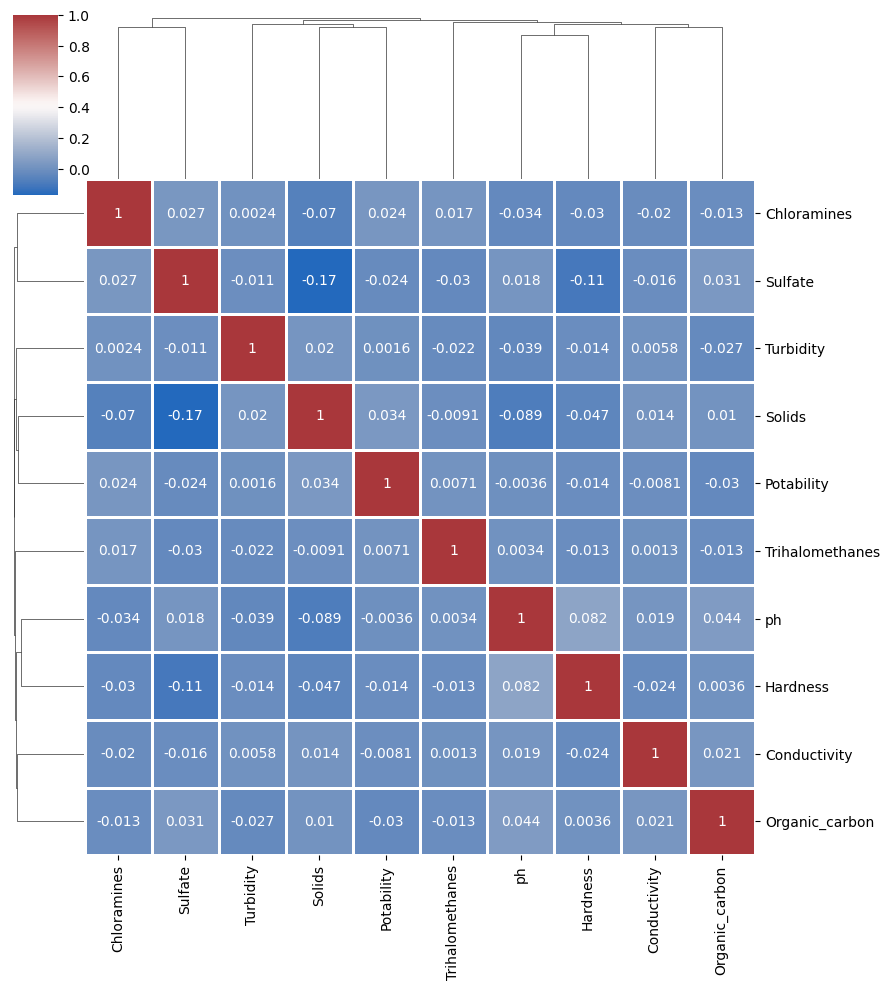

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.clustermap(df.corr(), cmap = "vlag", dendrogram_ratio = (0.1,0.2), annot = True, linewidth = 0.8, figsize = (9,10))
plt.show()

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Distrubition of Features :**

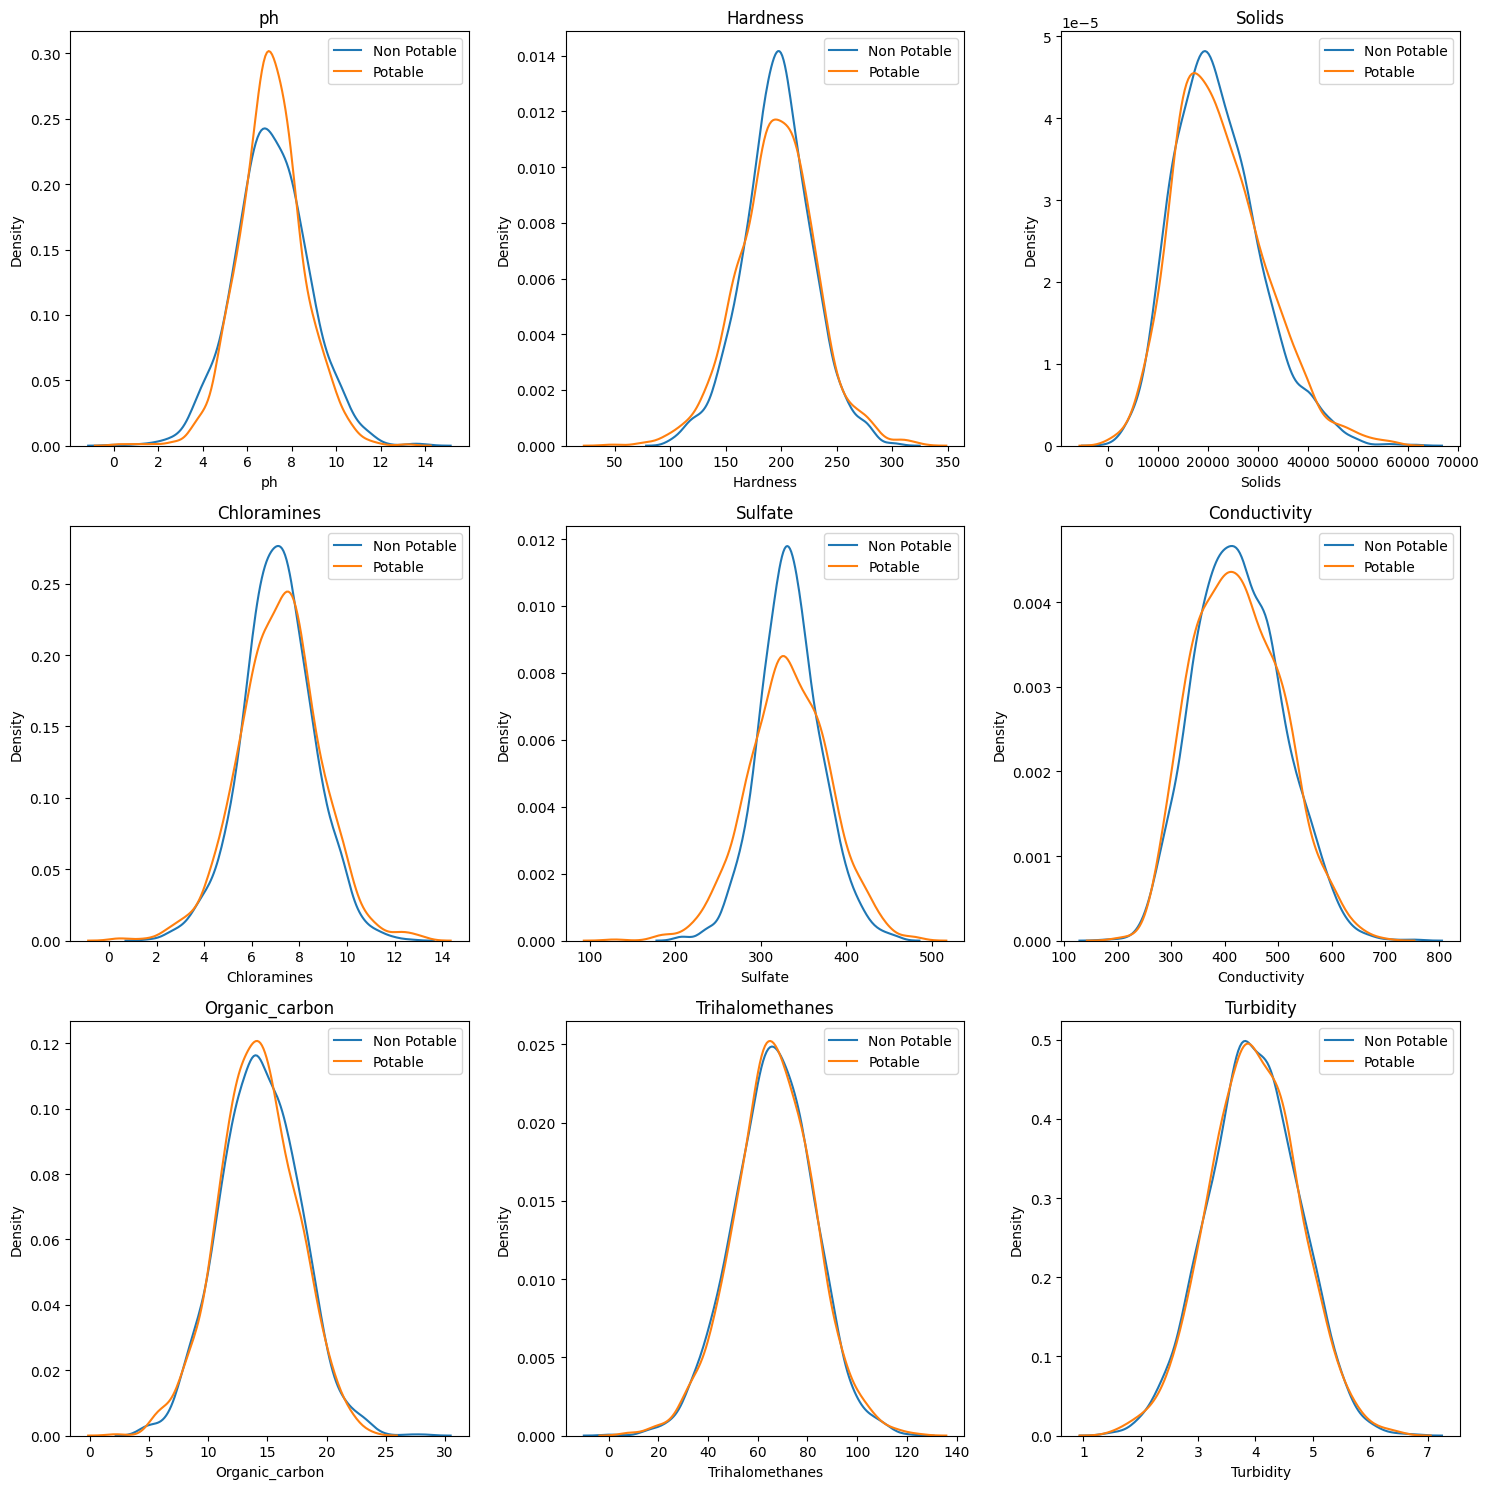

In [10]:
non_potable = df.query("Potability == 0")
potable = df.query("Potability == 1")

plt.figure(figsize = (15,15))
for ax,col in enumerate(df.columns[:9]):
    plt.subplot(3,3, ax + 1)
    plt.title(col)
    sns.kdeplot(x = non_potable[col], label = "Non Potable")
    sns.kdeplot(x = potable[col], label = "Potable")
    plt.legend()

plt.tight_layout()

In [11]:
df["ph"].fillna(value = df["ph"].median(), inplace = True)
df["Sulfate"].fillna(value = df["Sulfate"].median(), inplace = True)
df["Trihalomethanes"].fillna(value = df["Trihalomethanes"].median(), inplace = True)

<ipython-input-11-97b0ffde3f01>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-11-97b0ffde3f01>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

In [12]:
df.isnull().sum()

,0
ph,0
Hardness,0
Solids,0
Chloramines,0
Sulfate,0
Conductivity,0
Organic_carbon,0
Trihalomethanes,0
Turbidity,0
Potability,0


In [13]:
# split data into X and y
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [14]:
from sklearn.model_selection import train_test_split # to split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2620, 9)
(2620,)
(656, 9)
(656,)


In [16]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
y_pred = model.predict(X)
print(y_pred.shape)

(3276,)


In [18]:
y.shape

(3276,)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y,y_pred)

0.924908424908425

In [20]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
cm=confusion_matrix(y,y_pred)
print(cm)

[[1908   90]
 [ 156 1122]]


<Axes: >

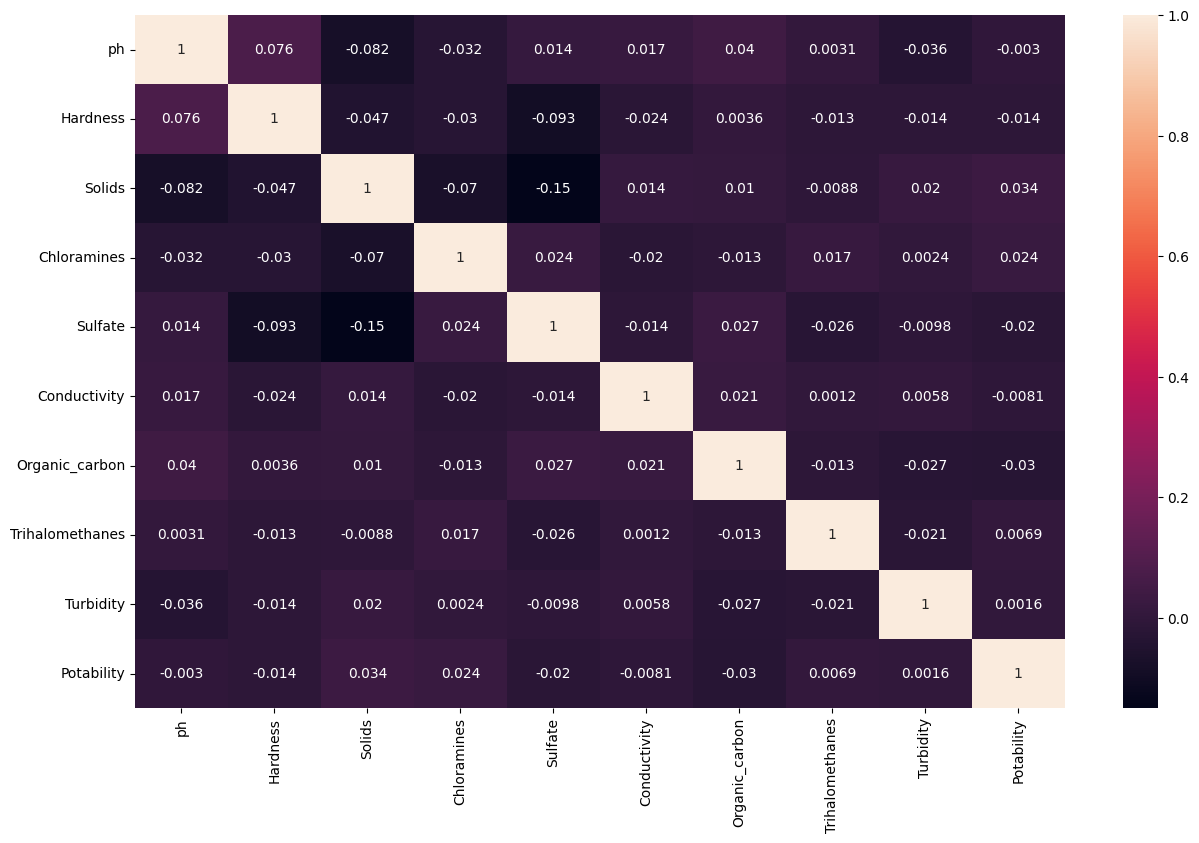

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (15,9))
sns.heatmap(df.corr(), annot = True)

In [23]:
# Example: Saving a scikit-learn model using pickle
import pickle
with open('BigModel.pkl', 'wb') as Trained_Model:
    pickle.dump(model, Trained_Model)

# Example: Saving an XGBoost model using its native method
model.save_model('model.bst') # Use save_model from XGBoost instead of save from Keras

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[14:33:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.



In [ ]:
from flask import Flask, request, jsonify, render_template
import pickle

app = Flask(__name__)

# Load the trained model (XGBoost)
# model = pickle.load(open('model.pkl', 'rb'))
with open('model.pkl', 'rb') as Trained_Model:
    model = pickle.load(Trained_Model)

# Define the home route with the HTML form
@app.route('/')
def home():
    return render_template('index.html')

# Define the route to evaluate water quality based on form input
@app.route('/evaluate', methods=['POST'])
def evaluate():
    # Retrieve input parameters from the form
    ph = float(request.form['ph'])
    hardness = float(request.form['hardness'])
    solids = float(request.form['solids'])
    chloramines = float(request.form['chloramines'])
    sulfate = float(request.form['sulfate'])
    conductivity = float(request.form['conductivity'])
    organic_carbon = float(request.form['organic_carbon'])
    trihalomethanes = float(request.form['trihalomethanes'])
    turbidity = float(request.form['turbidity'])

    # Create a feature array for the model
    input_features = np.array([[ph, hardness, solids, chloramines, sulfate, conductivity, organic_carbon, trihalomethanes, turbidity]])

    # Predict using the model
    prediction = model.predict(input_features)

    # Return result
    result = "Potable" if prediction[0] == 1 else "Not Potable"
    return render_template('result.html', result=result)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


In [ ]:
!python API.py

python3: can't open file '/content/app.py': [Errno 2] No such file or directory
